## 1. 라이브러리 설치 및 불러오기  
YOLO 모델을 실행하기 위한 환경을 구성하는 코드입니다.  
필요한 패키지를 설치하고, 이미지 처리 및 데이터 로딩에 필요한 라이브러리를 불러옵니다.

> ✅ 설치 패키지
- `ultralytics`: YOLO 모델 실행 및 학습
- `opencv-python`: 이미지 로딩 및 전처리
- `numpy`, `matplotlib`: 데이터 처리 및 시각화

> ✅ 불러오는 핵심 라이브러리
- `torch`, `torchvision`: 모델 학습 및 데이터 전처리
- `ultralytics.YOLO`: YOLO 모델 로딩
- `cv2`, `numpy`: 이미지 처리 및 수치 계산
- `tqdm`, `matplotlib.pyplot`: 시각화 및 진행 표시

In [14]:
!pip install ultralytics opencv-python numpy matplotlib tqdm pyyaml -q

import os
import cv2
import torch
import yaml
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from ultralytics import YOLO
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

## 2. 랜덤 시드 고정

실험의 일관성을 유지하기 위해 `random`, `numpy`, `torch`의 시드를 고정합니다.  

In [15]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
seed_everything()

## 3. 데이터 경로 설정 및 YAML 파일 로드
`data.yaml` 파일을 불러와 학습(train), 검증(val) 데이터의 경로를 설정합니다.

> ✅ 학습 데이터는 모델을 학습시키는 데 사용되며,  
> ✅ 검증 데이터는 학습 중 모델의 성능을 평가하고 과적합 여부를 확인하는 데 사용됩니다.

In [16]:
DATA_YAML_PATH = "/kaggle/input/pothole-detection-challenge/data.yaml"

with open(DATA_YAML_PATH, "r", encoding="utf-8") as f:
    data_yaml = yaml.safe_load(f)

DATASET_PATH = os.path.dirname(DATA_YAML_PATH)
TRAIN_IMAGES = os.path.join(DATASET_PATH, data_yaml["train"].replace("../", ""))
VALID_IMAGES = os.path.join(DATASET_PATH, data_yaml["val"].replace("../", ""))

print(DATASET_PATH)
print(TRAIN_IMAGES)
print(VALID_IMAGES)

/kaggle/input/pothole-detection-challenge
/kaggle/input/pothole-detection-challenge/train/images
/kaggle/input/pothole-detection-challenge/valid/images


## 4. 데이터셋 클래스 정의 및 로드  
객체 탐지 모델을 위한 이미지 데이터셋을 생성하고 불러오는 과정입니다.  
OpenCV와 glob을 활용하여 이미지를 로드하고, torchvision.transforms를 적용해  
크기 변환 및 텐서 변환을 수행합니다.  
마지막으로 샘플 이미지를 시각화하여 데이터가 올바르게 불러와졌는지 확인합니다.

훈련 데이터 샘플


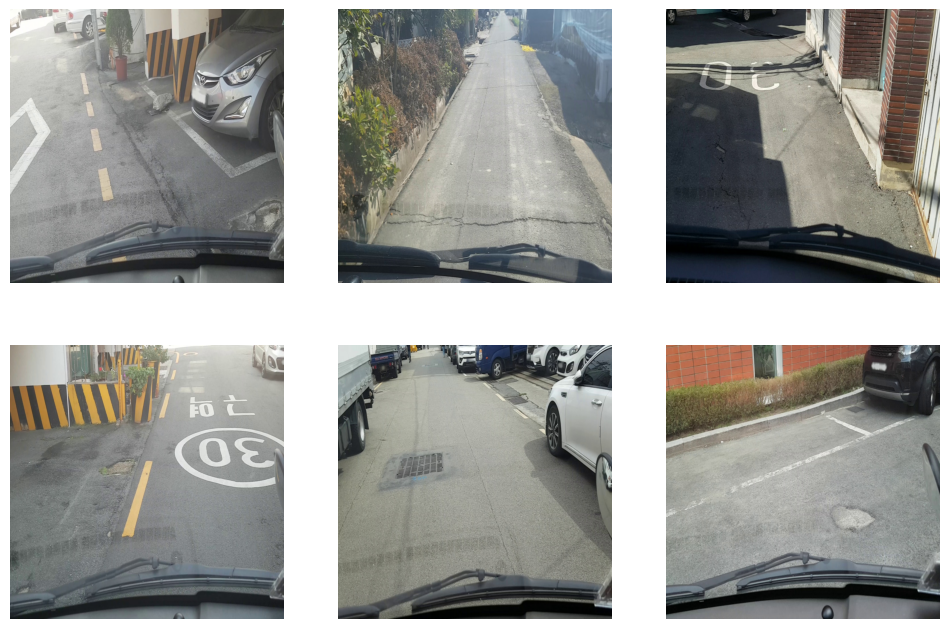

In [17]:
class PotholeDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = glob(os.path.join(image_dir, "*.jpg"))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        return self.transform(img) if self.transform else img


transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
])

train_loader = DataLoader(PotholeDataset(TRAIN_IMAGES, transform), batch_size=16, shuffle=True)
valid_loader = DataLoader(PotholeDataset(VALID_IMAGES, transform), batch_size=16, shuffle=False)


def show_sample_images(image_loader):
    sample_images = next(iter(image_loader))

    fig, ax = plt.subplots(2, 3, figsize=(12, 8))

    for i, img in enumerate(sample_images[:6]):
        ax[i // 3, i % 3].imshow(img.permute(1, 2, 0).numpy())
        ax[i // 3, i % 3].axis("off")

    plt.show()


print("훈련 데이터 샘플")
show_sample_images(train_loader)

## 5. 랜덤 샘플 시각화 (이미지 + 라벨)

학습 이미지 중 하나를 랜덤으로 선택하여 해당 이미지와 라벨 정보를 시각화합니다.  
라벨은 YOLO 포맷의 좌표 정보를 바탕으로 이미지 위에 바운딩 박스를 그려 확인합니다.


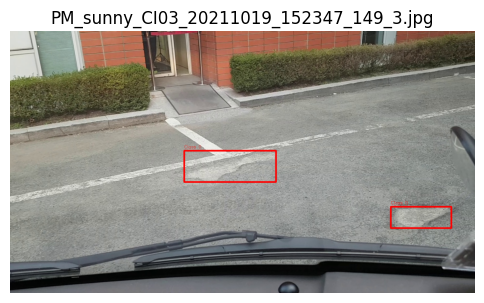

In [18]:
IMAGE_DIR = "/kaggle/input/pothole-detection-challenge/train/images"
IMAGE_PATHS = sorted(glob(os.path.join(IMAGE_DIR, "*.jpg")))

IMG_PATH = random.choice(IMAGE_PATHS)
LABEL_PATH = IMG_PATH.replace("images", "labels").replace(".jpg", ".txt")

img = cv2.imread(IMG_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w, _ = img.shape

if os.path.exists(LABEL_PATH):
    with open(LABEL_PATH, "r") as f:
        for line in f.readlines():
            cls, cx, cy, bw, bh = map(float, line.strip().split())
            x1 = int((cx - bw / 2) * w)
            y1 = int((cy - bh / 2) * h)
            x2 = int((cx + bw / 2) * w)
            y2 = int((cy + bh / 2) * h)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 5)
            cv2.putText(img, f"Class {int(cls)}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 1)
else:
    print("라벨 파일이 존재하지 않습니다:", LABEL_PATH)

# 시각화
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis("off")
plt.title(os.path.basename(IMG_PATH))
plt.show()

## 6. YOLO 모델 학습  
YOLO 모델을 불러와 학습을 수행하는 코드입니다.  
데이터셋 경로를 지정하고, 에포크 수 및 배치 크기를 설정하여 학습을 진행합니다.
- 기본적으로 YOLO 학습 결과는 `runs/detect/train` 디렉토리에 저장됩니다.  
- 캐글 환경에서는 저장 경로를 직접 지정해야 합니다.
- `project` 및 `name` 파라미터를 사용하여 원하는 경로에 저장할 수 있습니다.

In [19]:
model = YOLO("/kaggle/working/pothole_yolov8_train/weights/best.pt")

def train_model():
    results = model.train(
        data=DATA_YAML_PATH,
        epochs=60,
        patience=10,  # 성능 향상 없으면 10 에폭 후 중지
        imgsz=640,
        batch=-1,
        workers=4,
        device="0",
        project="/kaggle/working",
        name="pothole_yolov8_train"
    )
    return results

results = train_model()

Ultralytics 8.3.121 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/pothole_yolov8_train/weights/best.pt, data=/kaggle/input/pothole-detection-challenge/data.yaml, epochs=60, time=None, patience=10, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=4, project=/kaggle/working, name=pothole_yolov8_train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_c

train: Scanning /kaggle/input/pothole-detection-challenge/train/labels... 24279 images, 0 backgrounds, 11 corrupt: 100%|██████████| 24290/24290 [01:16<00:00, 316.02it/s]

train: /kaggle/input/pothole-detection-challenge/train/images/AM_sunny_CI02_20211020_112426_804_3.jpg: ignoring corrupt image/label: cannot identify image file '/kaggle/input/pothole-detection-challenge/train/images/AM_sunny_CI02_20211020_112426_804_3.jpg'
train: /kaggle/input/pothole-detection-challenge/train/images/AM_sunny_CI02_20211020_112426_805_1.jpg: ignoring corrupt image/label: [Errno 30] Read-only file system: '/kaggle/input/pothole-detection-challenge/train/images/AM_sunny_CI02_20211020_112426_805_1.jpg'
train: /kaggle/input/pothole-detection-challenge/train/images/AM_sunny_CI02_20211020_112426_806_3.jpg: ignoring corrupt image/label: cannot identify image file '/kaggle/input/pothole-detection-challenge/train/images/AM_sunny_CI02_20211020_112426_806_3.jpg'
train: /kaggle/input/pothole-detection-challenge/train/images/AM_sunny_CI02_20211020_112426_808_3.jpg: ignoring corrupt image/label: image file is truncated (6 bytes not processed)
train: /kaggle/input/pothole-detection-ch

WARNING ⚠️ train: Cache directory /kaggle/input/pothole-detection-challenge/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.74G total, 0.37G reserved, 0.18G allocated, 14.19G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     3011043       8.194         0.396         21.37         67.84        (1, 3, 640, 640)                    list
     3011043       16.39         0.543         20.97         63.78        (2, 3, 640, 640)                    list
     3011043       32.78         0.849         22.77         63.21        (4, 3, 640, 640)                    list
     3011043       65.55         

train: Scanning /kaggle/input/pothole-detection-challenge/train/labels... 24279 images, 0 backgrounds, 11 corrupt: 100%|██████████| 24290/24290 [00:25<00:00, 942.50it/s] 

train: /kaggle/input/pothole-detection-challenge/train/images/AM_sunny_CI02_20211020_112426_804_3.jpg: ignoring corrupt image/label: cannot identify image file '/kaggle/input/pothole-detection-challenge/train/images/AM_sunny_CI02_20211020_112426_804_3.jpg'
train: /kaggle/input/pothole-detection-challenge/train/images/AM_sunny_CI02_20211020_112426_805_1.jpg: ignoring corrupt image/label: [Errno 30] Read-only file system: '/kaggle/input/pothole-detection-challenge/train/images/AM_sunny_CI02_20211020_112426_805_1.jpg'
train: /kaggle/input/pothole-detection-challenge/train/images/AM_sunny_CI02_20211020_112426_806_3.jpg: ignoring corrupt image/label: cannot identify image file '/kaggle/input/pothole-detection-challenge/train/images/AM_sunny_CI02_20211020_112426_806_3.jpg'
train: /kaggle/input/pothole-detection-challenge/train/images/AM_sunny_CI02_20211020_112426_808_3.jpg: ignoring corrupt image/label: image file is truncated (6 bytes not processed)
train: /kaggle/input/pothole-detection-ch

WARNING ⚠️ train: Cache directory /kaggle/input/pothole-detection-challenge/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 1.5±1.5 ms, read: 370.9±115.1 MB/s, size: 554.1 KB)


val: Scanning /kaggle/input/pothole-detection-challenge/valid/labels... 5998 images, 0 backgrounds, 2 corrupt: 100%|██████████| 6000/6000 [00:14<00:00, 427.80it/s]

val: /kaggle/input/pothole-detection-challenge/valid/images/AM_sunny_CI02_20211020_112426_809_2.jpg: ignoring corrupt image/label: broken data stream when reading image file
val: /kaggle/input/pothole-detection-challenge/valid/images/AM_sunny_CI02_20211020_112426_813_1.jpg: ignoring corrupt image/label: cannot identify image file '/kaggle/input/pothole-detection-challenge/valid/images/AM_sunny_CI02_20211020_112426_813_1.jpg'


WARNING ⚠️ val: Cache directory /kaggle/input/pothole-detection-challenge/valid is not writeable, cache not saved.
Plotting labels to /kaggle/working/pothole_yolov8_train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00046875), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/pothole_yolov8_train2
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      7.36G      1.595      1.331      1.127        174        640: 100%|██████████| 405/405 [05:40<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:47<00:00,  1.04it/s]


                   all       5998      15797       0.64      0.455      0.517      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      7.18G      1.595      1.272      1.115        177        640: 100%|██████████| 405/405 [05:28<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:54<00:00,  1.09s/it]


                   all       5998      15797      0.647      0.506      0.567      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      7.14G      1.659       1.34      1.141        192        640: 100%|██████████| 405/405 [05:32<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:49<00:00,  1.02it/s]


                   all       5998      15797      0.502      0.344      0.353       0.19

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      7.08G      1.684      1.373      1.153        183        640: 100%|██████████| 405/405 [05:25<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:46<00:00,  1.09it/s]


                   all       5998      15797      0.649      0.494      0.547       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      7.19G      1.617      1.288      1.133        197        640: 100%|██████████| 405/405 [05:26<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:49<00:00,  1.02it/s]


                   all       5998      15797      0.668      0.503      0.567      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      7.17G      1.581      1.232      1.117        168        640: 100%|██████████| 405/405 [05:29<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:49<00:00,  1.01it/s]

                   all       5998      15797      0.633      0.429      0.494      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      7.04G      1.542      1.182      1.102        170        640: 100%|██████████| 405/405 [05:27<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:46<00:00,  1.09it/s]

                   all       5998      15797       0.68      0.496      0.583      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      7.19G       1.51      1.136      1.088        131        640: 100%|██████████| 405/405 [05:25<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


                   all       5998      15797      0.734      0.588      0.678      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      7.31G      1.491      1.106      1.081        189        640: 100%|██████████| 405/405 [05:21<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


                   all       5998      15797      0.725      0.598      0.681      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      7.05G       1.47      1.078      1.074        213        640: 100%|██████████| 405/405 [05:21<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


                   all       5998      15797      0.735      0.575      0.663      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      7.44G      1.453      1.054      1.065        189        640: 100%|██████████| 405/405 [05:21<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


                   all       5998      15797      0.757      0.628      0.719      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      7.04G       1.43       1.03       1.06        151        640: 100%|██████████| 405/405 [05:24<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


                   all       5998      15797       0.78      0.635      0.736      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      7.14G      1.419      1.008      1.053        224        640: 100%|██████████| 405/405 [05:23<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


                   all       5998      15797      0.773      0.628      0.727      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      7.17G      1.402     0.9905      1.046        164        640: 100%|██████████| 405/405 [05:31<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


                   all       5998      15797      0.796      0.661      0.762      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      7.24G      1.395     0.9747      1.044        162        640: 100%|██████████| 405/405 [05:21<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


                   all       5998      15797      0.806      0.672      0.771      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      7.19G      1.386     0.9726       1.04        180        640: 100%|██████████| 405/405 [05:20<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


                   all       5998      15797      0.794      0.664      0.764      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      7.19G      1.372       0.95      1.036        167        640: 100%|██████████| 405/405 [05:23<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


                   all       5998      15797      0.807      0.685      0.784      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      7.14G      1.356     0.9325       1.03        218        640: 100%|██████████| 405/405 [05:22<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:46<00:00,  1.08it/s]

                   all       5998      15797      0.822      0.692      0.795      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      7.19G      1.353     0.9279      1.028        210        640: 100%|██████████| 405/405 [05:21<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:46<00:00,  1.07it/s]

                   all       5998      15797      0.816      0.703        0.8       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      7.11G      1.355      0.924      1.027        196        640: 100%|██████████| 405/405 [05:22<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


                   all       5998      15797      0.823       0.71      0.808      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      7.04G      1.333     0.9037       1.02        159        640: 100%|██████████| 405/405 [05:20<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:46<00:00,  1.07it/s]

                   all       5998      15797      0.839      0.713      0.817      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      7.04G      1.324     0.8911      1.016        152        640: 100%|██████████| 405/405 [05:22<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:46<00:00,  1.07it/s]

                   all       5998      15797      0.837      0.725      0.824      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      7.13G      1.312     0.8791      1.013        164        640: 100%|██████████| 405/405 [05:22<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:48<00:00,  1.03it/s]

                   all       5998      15797      0.845      0.728       0.83      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      7.11G      1.309     0.8729      1.011        157        640: 100%|██████████| 405/405 [05:20<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


                   all       5998      15797      0.842      0.732      0.831      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      7.16G      1.307     0.8678       1.01        204        640: 100%|██████████| 405/405 [05:19<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:45<00:00,  1.09it/s]

                   all       5998      15797      0.842      0.736      0.837      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      7.11G      1.299     0.8573      1.005        195        640: 100%|██████████| 405/405 [05:20<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:46<00:00,  1.08it/s]

                   all       5998      15797      0.846      0.746      0.842      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      7.24G      1.291     0.8481      1.004        186        640: 100%|██████████| 405/405 [05:21<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:48<00:00,  1.03it/s]

                   all       5998      15797      0.843      0.754      0.845      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      7.17G      1.283     0.8394      1.002        191        640: 100%|██████████| 405/405 [05:22<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:45<00:00,  1.10it/s]

                   all       5998      15797      0.856       0.75      0.849      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      7.13G      1.279      0.836      1.001        173        640: 100%|██████████| 405/405 [05:22<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:46<00:00,  1.08it/s]

                   all       5998      15797      0.847       0.76      0.851      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      7.11G      1.267     0.8226     0.9967        156        640: 100%|██████████| 405/405 [05:21<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:46<00:00,  1.08it/s]

                   all       5998      15797      0.855      0.753      0.852      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      7.17G      1.266     0.8203     0.9945        181        640: 100%|██████████| 405/405 [05:21<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:46<00:00,  1.08it/s]

                   all       5998      15797      0.853       0.76      0.856      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      7.16G      1.255     0.8105     0.9909        170        640: 100%|██████████| 405/405 [05:22<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:47<00:00,  1.04it/s]

                   all       5998      15797      0.857      0.761      0.859      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      7.11G      1.253     0.8036     0.9897        143        640: 100%|██████████| 405/405 [05:24<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:45<00:00,  1.10it/s]

                   all       5998      15797       0.86      0.761      0.861      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      7.17G      1.241     0.7927     0.9863        161        640: 100%|██████████| 405/405 [05:19<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:48<00:00,  1.02it/s]

                   all       5998      15797      0.865      0.762      0.863       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      7.13G      1.243     0.7943      0.987        179        640: 100%|██████████| 405/405 [05:19<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:46<00:00,  1.07it/s]

                   all       5998      15797      0.862      0.765      0.864      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      7.11G      1.232     0.7827     0.9835        181        640: 100%|██████████| 405/405 [05:20<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:47<00:00,  1.06it/s]

                   all       5998      15797      0.865      0.767      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      7.47G      1.228     0.7791     0.9826        195        640: 100%|██████████| 405/405 [05:22<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:47<00:00,  1.04it/s]

                   all       5998      15797      0.861      0.775      0.866      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      7.17G      1.221     0.7721     0.9804        138        640: 100%|██████████| 405/405 [05:24<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]

                   all       5998      15797      0.863      0.777      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      7.17G      1.222     0.7655     0.9785        166        640: 100%|██████████| 405/405 [05:20<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:46<00:00,  1.08it/s]

                   all       5998      15797      0.866      0.777      0.869      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      7.12G      1.215     0.7584     0.9766        175        640: 100%|██████████| 405/405 [05:24<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:46<00:00,  1.07it/s]

                   all       5998      15797      0.867      0.775       0.87      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      7.17G      1.205     0.7496     0.9734        173        640: 100%|██████████| 405/405 [05:19<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:46<00:00,  1.07it/s]

                   all       5998      15797      0.867      0.777      0.871       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      7.12G      1.199     0.7443     0.9722        186        640: 100%|██████████| 405/405 [05:19<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:47<00:00,  1.06it/s]

                   all       5998      15797      0.865       0.78      0.872      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      7.23G      1.198     0.7412     0.9705        188        640: 100%|██████████| 405/405 [05:21<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:45<00:00,  1.10it/s]

                   all       5998      15797      0.867       0.78      0.872      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      7.22G      1.186     0.7357     0.9684        193        640: 100%|██████████| 405/405 [05:20<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:46<00:00,  1.08it/s]

                   all       5998      15797      0.867      0.782      0.873      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      7.11G      1.186      0.728     0.9673        197        640: 100%|██████████| 405/405 [05:18<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:46<00:00,  1.07it/s]

                   all       5998      15797      0.869      0.782      0.874      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      7.26G      1.179     0.7243     0.9662        163        640: 100%|██████████| 405/405 [05:20<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:45<00:00,  1.09it/s]

                   all       5998      15797      0.872       0.78      0.875      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      7.13G      1.164     0.7127     0.9621        144        640: 100%|██████████| 405/405 [05:20<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:46<00:00,  1.08it/s]

                   all       5998      15797      0.871      0.783      0.875      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      7.45G      1.164     0.7106     0.9635        202        640: 100%|██████████| 405/405 [05:19<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:46<00:00,  1.07it/s]

                   all       5998      15797      0.874      0.782      0.876      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      7.15G      1.166     0.7106      0.961        173        640: 100%|██████████| 405/405 [05:20<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:45<00:00,  1.10it/s]

                   all       5998      15797      0.874      0.783      0.876      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      7.46G      1.154     0.6997     0.9567        231        640: 100%|██████████| 405/405 [05:19<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:45<00:00,  1.09it/s]

                   all       5998      15797      0.873      0.784      0.877      0.597


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      7.09G      1.122     0.6667     0.9576         90        640: 100%|██████████| 405/405 [05:15<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:49<00:00,  1.02it/s]

                   all       5998      15797      0.873      0.785      0.878      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      7.03G      1.107     0.6505     0.9517        117        640: 100%|██████████| 405/405 [05:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:48<00:00,  1.04it/s]

                   all       5998      15797      0.873      0.786      0.878      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      7.03G      1.099     0.6397     0.9479         92        640: 100%|██████████| 405/405 [05:10<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:46<00:00,  1.08it/s]

                   all       5998      15797      0.873      0.786      0.879      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      7.09G      1.086     0.6316     0.9456         96        640: 100%|██████████| 405/405 [05:12<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:46<00:00,  1.07it/s]

                   all       5998      15797      0.874      0.786      0.879      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      7.11G      1.081     0.6236     0.9431        110        640: 100%|██████████| 405/405 [05:16<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:47<00:00,  1.06it/s]

                   all       5998      15797      0.875      0.786       0.88        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      7.08G      1.074     0.6152     0.9424         85        640: 100%|██████████| 405/405 [05:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:45<00:00,  1.09it/s]

                   all       5998      15797      0.875      0.787       0.88        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      7.09G      1.066     0.6072     0.9394         92        640: 100%|██████████| 405/405 [05:10<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:45<00:00,  1.09it/s]

                   all       5998      15797      0.875      0.788      0.881      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      7.12G      1.057     0.6004     0.9358         86        640: 100%|██████████| 405/405 [05:08<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:45<00:00,  1.09it/s]

                   all       5998      15797      0.877      0.787      0.881      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      7.11G       1.05     0.5935     0.9338        108        640: 100%|██████████| 405/405 [05:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:47<00:00,  1.06it/s]

                   all       5998      15797      0.878      0.788      0.882      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      7.13G      1.043     0.5885     0.9322        109        640: 100%|██████████| 405/405 [05:11<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:46<00:00,  1.08it/s]

                   all       5998      15797      0.882      0.786      0.883      0.604



60 epochs completed in 6.159 hours.
Optimizer stripped from /kaggle/working/pothole_yolov8_train2/weights/last.pt, 6.2MB
Optimizer stripped from /kaggle/working/pothole_yolov8_train2/weights/best.pt, 6.2MB

Validating /kaggle/working/pothole_yolov8_train2/weights/best.pt...
Ultralytics 8.3.121 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


                   all       5998      15797      0.881      0.786      0.883      0.604


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to /kaggle/working/pothole_yolov8_train2


## 7. 학습 결과 시각화

YOLO 모델 학습 과정에서 저장된 손실 그래프(`results.png`)를 불러와 시각화하는 코드입니다.  
`matplotlib`을 사용하여 이미지를 출력하고, 그래프 외 요소는 제거하여 깔끔하게 보여줍니다.

- 기본적으로 학습 결과는 `runs/detect/train` 디렉토리에 저장됩니다.  
- 캐글 환경에서는 저장된 경로를 명시적으로 지정해주어야 합니다.


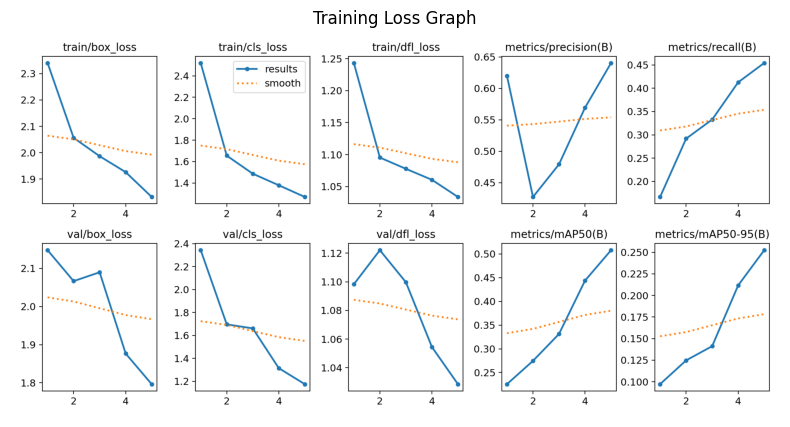

In [20]:
TRAIN_RUN_DIR = "/kaggle/working/pothole_yolov8_train"
loss_plot_path = f"{TRAIN_RUN_DIR}/results.png"

img = plt.imread(loss_plot_path)
plt.figure(figsize=(10, 5))
plt.imshow(img)
plt.axis("off")
plt.title("Training Loss Graph")
plt.show()

## 8. 모델 성능 평가  
학습된 YOLO 모델을 불러와 검증 데이터셋을 이용해 성능을 평가하는 코드입니다.  
`val()` 함수를 사용하여 `mAP`, `Precision`, `Recall` 등의 성능 지표를 계산합니다.

- 캐글 환경에서는 모델이 저장된 경로를 지정해줘야 합니다.


In [21]:
model = YOLO("/kaggle/working/pothole_yolov8_train/weights/best.pt")

val_results = model.val(data=DATA_YAML_PATH, split="val")

print("검증 데이터 평가 결과:")
print(f"mAP50: {val_results.box.map50:.4f}")
print(f"mAP50-95: {val_results.box.map:.4f}")
print(f"Precision: {val_results.box.mp:.4f}")
print(f"Recall: {val_results.box.mr:.4f}")

Ultralytics 8.3.121 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1013.2±232.6 MB/s, size: 721.5 KB)


val: Scanning /kaggle/input/pothole-detection-challenge/valid/labels... 5998 images, 0 backgrounds, 2 corrupt: 100%|██████████| 6000/6000 [00:06<00:00, 967.15it/s] 

val: /kaggle/input/pothole-detection-challenge/valid/images/AM_sunny_CI02_20211020_112426_809_2.jpg: ignoring corrupt image/label: broken data stream when reading image file
val: /kaggle/input/pothole-detection-challenge/valid/images/AM_sunny_CI02_20211020_112426_813_1.jpg: ignoring corrupt image/label: cannot identify image file '/kaggle/input/pothole-detection-challenge/valid/images/AM_sunny_CI02_20211020_112426_813_1.jpg'


WARNING ⚠️ val: Cache directory /kaggle/input/pothole-detection-challenge/valid is not writeable, cache not saved.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:41<00:00,  8.94it/s]


                   all       5998      15797      0.638      0.456      0.509      0.253


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/val2
검증 데이터 평가 결과:
mAP50: 0.5092
mAP50-95: 0.2529
Precision: 0.6381
Recall: 0.4564


## 9. 모델 추론 및 시각화
학습된 YOLO 모델을 사용하여 테스트 데이터셋에서 임의의 이미지를 추론합니다.

- 포트홀을 감지하지 못하면 아무것도 표시되지 않습니다.


image 1/1 /kaggle/input/pothole-detection-challenge/test/images/PM_wetsunny_CI02_20211021_152554_423_2.jpg: 384x640 2 potholes, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


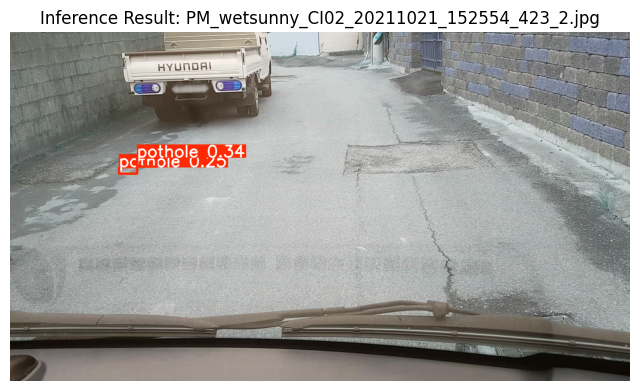

In [22]:
model = YOLO("/kaggle/working/pothole_yolov8_train/weights/best.pt")

TEST_IMAGE_DIR = "/kaggle/input/pothole-detection-challenge/test/images"
test_image_paths = sorted(glob(os.path.join(TEST_IMAGE_DIR, "*.jpg")))
test_img_path = random.choice(test_image_paths)

results = model.predict(source=test_img_path, conf=0.25, imgsz=640, save=False)

result_img = results[0].plot()

plt.figure(figsize=(8, 6))
plt.imshow(result_img)
plt.axis("off")
plt.title(f"Inference Result: {os.path.basename(test_img_path)}")
plt.show()

## 10. 제출 파일 생성 (submission.csv)
테스트 이미지에 대해 학습된 YOLO 모델을 사용하여 객체 탐지를 수행하고,  
예측 결과를 제출 형식에 맞춰 `submission.csv` 파일로 저장합니다.

- 한 이미지당 박스 하나만 제출하며, confidence가 가장 높은 박스를 사용합니다.
- 객체를 감지하지 못한 경우, `ClassId`와 바운딩 박스 좌표는 모두 0으로 처리합니다.
- 이미지가 손상되었거나 열리지 않는 경우에도 에러 없이 넘어가도록 예외 처리를 포함합니다.
- Output 경로인 /kagggle/working/에 저장됩니다.

In [ ]:
import pandas as pd
from ultralytics import YOLO


model = YOLO("/kaggle/working/pothole_yolov8_train/weights/best.pt")

TEST_IMG_DIR = "/kaggle/input/pothole-detection-challenge/test/images"
test_image_paths = sorted(glob(os.path.join(TEST_IMG_DIR, "*.jpg")))

submission_rows = []

for img_path in test_image_paths:
    image_id = os.path.basename(img_path)

    if cv2.imread(img_path) is None:
        print(f"이미지 로드 실패: {image_id}")
        submission_rows.append({
            "ImageId": image_id,
            "ClassId": 0,
            "X": 0,
            "Y": 0,
            "Width": 0,
            "Height": 0,
        })
        continue

    results = model.predict(source=img_path, conf=0.25, imgsz=640, save=False)
    result = results[0]

    if len(result.boxes) > 0:
        boxes = result.boxes
        best_idx = boxes.conf.argmax().item()
        cls_id = int(boxes.cls[best_idx].item())
        cx, cy, w, h = boxes.xywhn[best_idx].tolist()

        submission_rows.append({
            "ImageId": image_id,
            "ClassId": cls_id,
            "X": round(cx, 6),
            "Y": round(cy, 6),
            "Width": round(w, 6),
            "Height": round(h, 6),
        })
    else:
        submission_rows.append({
            "ImageId": image_id,
            "ClassId": 0,
            "X": 0,
            "Y": 0,
            "Width": 0,
            "Height": 0,
        })

submission_df = pd.DataFrame(submission_rows, columns=["ImageId", "ClassId", "X", "Y", "Width", "Height"])
submission_path = "/kaggle/working/submission.csv"
submission_df.to_csv(submission_path, index=False)
print(f"제출 파일 저장 완료: {submission_path}")


image 1/1 /kaggle/input/pothole-detection-challenge/test/images/AM_sunny_CI01_20210916_105931_11_117_2.jpg: 384x640 1 pothole, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/input/pothole-detection-challenge/test/images/AM_sunny_CI01_20210916_105931_11_118_2.jpg: 384x640 (no detections), 6.1ms
Speed: 1.8ms preprocess, 6.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/input/pothole-detection-challenge/test/images/AM_sunny_CI01_20210916_105931_11_134_1.jpg: 384x640 (no detections), 6.0ms
Speed: 1.8ms preprocess, 6.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/input/pothole-detection-challenge/test/images/AM_sunny_CI01_20210916_105931_11_137_2.jpg: 384x640 (no detections), 6.1ms
Speed: 1.8ms preprocess, 6.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/input/pothole-detection-challenge/test/imag